<h2>HW 3</h2>
Matt Buchovecky
Astro 283

We wish to find and characterize the likelihood of certain parameters given the data, e.g. for flux:
$$ P\left(F\mid\{D_{x,y}\},I\right) $$  
Here are the givens:  
$k=3.0\frac{e^-}{DN}$ is the gain  
$N_e=kN_{DN}$ converts from digital counts to photoelectrons  
Because your counting statistics are done on the actual 
$\sigma_{DN}=\frac{1}{k}\sigma_N$  
The parameters can be put into a vector $\vec z$
$$ \vec z = \left(x_c, y_c, F, \sigma_{PSF}, B\right) $$

<h2>Finding the probability of a set of parameters</h2>
Since we are modelling the Point Spread Function to be a symmetric 2D gaussian with amplitude of the point flux $F$ at the true center, the expected signal at a location elsewhere will follow:  
$$  f\left(x,y,\vec z\right) = Fexp{\left[-\frac{\left(x-x_c\right)^2+\left(y-y_c\right)^2}{2\sigma_{PSF}^2}\right]} + B $$  
where B is a common background constant. The probability distribution for getting a signal given the flux parameter at a specific position follows a Poisson distribution:  \\
\begin{eqnarray} 
p\left(\vec{z}\mid D_{x,y}\right) &\propto& \prod_{x,y} \frac{f^De^{-f}}{D!} \\
&\propto& \prod_{x,y} \exp{\left[-\frac{\left(D_{x,y}-f\left(x,y,\vec z\right)\right)^2}{f\left(x,y,\vec z\right)}\right]} \\
&\approx\propto& \prod_{x,y} \exp{\left[-\frac{\left(D_{x,y}-f\left(x,y,\vec z\right)\right)^2}{D_{x,y}}\right]}
\end{eqnarray}  

The first approximation above is because our numbers of counts are high, so we can approximate the Poisson distribution as a Gaussian distribution. In order to make this a chi squared problem, we have to make a further approximation that the variance is the measured "flux", not the actual flux. Note, when I use the quantity of flux, I am referring to the expected flux number, in data counts, for the same time as the time of observation  

Since we have a chi square problem now, we can maximize the likelihood of the parameters by doing a least squares fit to $p\left(\vec{z}\mid D_{x,y}\right)$. This can be done in python with scipy.optimize using the curve_fit function, which will output the best fit parameters, as well as the covariance matrix $\Sigma$


To marginalize the data, we integrate over every other parameter:
$$ P\left(F\mid\{D_{x,y}\}\right) = \int p\left(\vec{z} \mid \{D_{x,y}\}, I\right)d\sigma dxdydB $$
$$ P\left(x_c,y_c\mid\{D_{x,y}\}\right) = \int p\left(\vec{z} \mid \{D_{x,y}\}, I\right)dFd\sigma dB $$  

As with the discussion example, the marginal distribution of $F$ will result in a gaussian with a mean of the optimal flux, and width of the square root of the variance taken from the fit's covariance matrix. The joint marginal distribution of $x_c$ and $y_c$ will be a 2d gaussian centered at $\left(x_c, y_c\right)$ with a covariance matrix, which is the small subset of the larger covariance matrix

$$
\Sigma^\prime = \left[
\begin{array}{ccc}
\sigma^{2}_{xx} & \sigma^{2}_{xy}\\
\sigma^{2}_{yx} & \sigma^{2}_{yy}
\end{array}
\right]
$$


<h1> Perform the fit and plot the data! </h1>

In [1]:
import numpy
from astropy.io import fits 
from scipy import optimize
from matplotlib import pyplot 
%matplotlib inline 


In [2]:
star_fits = fits.open("./hw3prob1-data.fits")
star_data = star_fits[0].data
star_rav = star_data.ravel()
print(star_fits[0].header)
#print(star_data)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  256                                                  NAXIS2  =                  256                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

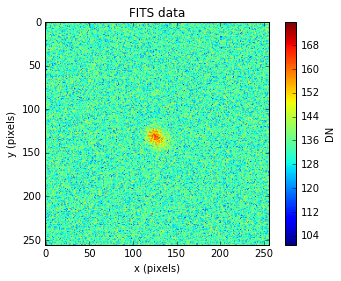

In [3]:
fig = pyplot.figure()
pyplot.imshow(star_data)
pyplot.xlabel('x (pixels)')
pyplot.ylabel('y (pixels)')
pyplot.title("FITS data")
cbar = pyplot.colorbar(label='DN')
cbar.solids.set_edgecolor('face')

In [4]:
def symm_2d_gaussian(pos, F, xc, yc, sigma, B):
    return F*numpy.exp(-((pos[0]-xc)**2+(pos[1]-yc)**2)/(2*sigma**2)) + B
    

In [5]:
x_bins = star_data.shape[0]
y_bins = star_data.shape[1]

# Create x and y indices
x_arr = numpy.linspace(0, x_bins-1, x_bins)
y_arr = numpy.linspace(0, y_bins-1, y_bins)
x_arr, y_arr = numpy.meshgrid(x_arr, y_arr)
coords = x_arr, y_arr

x_rav = x_arr.ravel()
y_rav = y_arr.ravel()


In [6]:
init_guess = (50, 130, 130, 20, 100)
sigma_array = numpy.sqrt(star_data)
p_opt, p_cov = optimize.curve_fit(symm_2d_gaussian, (x_rav, y_rav), star_rav, init_guess, sigma_array.ravel())


In [7]:
print("param name\tF \t\tx_center\ty_center\tPSF\t\tbackground")
param_string = "optimal value\t"
for i in range(0, len(p_opt)):
    param_string = param_string + "{0:0.5f} \t".format(p_opt[i])
print(param_string)
sigma_string = "variance\t"
for i in range(0, len(p_opt)):
    sigma_string = sigma_string + "{0:0.5f} \t".format(p_cov[i][i])
print(sigma_string)
print("\nCovariance matrix:")
print(p_cov)
F0 = p_opt[0]
F_sig = p_cov[0][0]
B0 = p_opt[4]


param name	F 		x_center	y_center	PSF		background
optimal value	26.19307 	125.97306 	132.45200 	7.12770 	133.01421 	
variance	0.63952 	0.04477 	0.04484 	0.02235 	0.00069 	

Covariance matrix:
[[  6.39519668e-01  -7.28903014e-04  -5.15137676e-04  -8.47618508e-02
    5.40768593e-05]
 [ -7.28903014e-04   4.47657074e-02   4.12282558e-04   9.38852077e-05
    1.73620946e-07]
 [ -5.15137676e-04   4.12282558e-04   4.48411725e-02   6.93613688e-05
    4.17841051e-08]
 [ -8.47618508e-02   9.38852077e-05   6.93613688e-05   2.23523731e-02
   -3.87444191e-04]
 [  5.40768593e-05   1.73620946e-07   4.17841051e-08  -3.87444191e-04
    6.92884736e-04]]


In [8]:
sigma_prime = numpy.matrix(p_cov[1:3,1:3])
sigma_inv = sigma_prime.I
det_sigma = numpy.linalg.det(sigma_prime)
print("determinant of sigma prime")
print(det_sigma)
print("inverse of sigma prime")
print(sigma_inv)
x_0_matrix = numpy.matrix([[125.973], [132.452]])


determinant of sigma prime
0.00200717683093
inverse of sigma prime
[[ 22.34041955  -0.2054042 ]
 [ -0.2054042   22.30282191]]


As stated above, the marginal probability of the flux will be: 
$$ p\left(F\mid\{D_{x,y}\}\right) = \frac{1}{\sqrt{2\pi}\sigma_{F}}e^{-\frac{\left(F-F_0\right)^2}{2\sigma_{F}^2}} $$  
which we can write as $F_0 = 26.193 \pm 0.640$  
<br>
Now we can find the joint marginal distribution for the center position $\vec{x} = \left(x_c, y_c\right)$  
The fit gives optimal parameters and covariance:  
$\vec{x}_0 = \left(125.973, 132.452\right)$ 
$\;$  
$\Sigma^\prime = \left[
\begin{array}{ccc}
4.477\times 10^{-2} & 4.123\times 10^{-4}\\
4.122\times 10^{-4} & 4.484\times 10^{-2}
\end{array}
\right]
$  
The form of the joint marginal probability distribution is here, the $\Sigma^{\prime}$ matrix, its determinant, and inverse are found and shown above:   
$$ p\left(\vec{x}\mid\{D_{x,y}\}\right) = \frac{1}{\sqrt{\left(2\pi\right)^2\left|{\Sigma^\prime}\right|}}\exp{\left[-\frac{1}{2}\left(\vec{x}-\vec{x}_0\right)^T\Sigma^{\prime -1}\left(\vec{x}-\vec{x_0}\right)\right]} $$  



In [9]:
x_0_matrix = numpy.matrix([[125.973], [132.452]])
mat_prod = numpy.dot(x_0_matrix.T, numpy.dot(sigma_inv, x_0_matrix))
print(mat_prod)
print(0.5*x_0_matrix.T*sigma_inv*x_0_matrix)

[[ 738940.29676859]]
[[ 369470.14838429]]


In [10]:
def joint_marginal_dist_2(pos, center, cov_mat):
    if type(pos) is not numpy.matrix:
        pos = numpy.matrix(pos)
    return 1/((2*numpy.pi)*numpy.sqrt(numpy.linalg.det(cov_mat)))*numpy.exp(-0.5*(pos-center).T*cov_mat.I*(pos-center))
# mat1 * mat2 equivalent to numpy.dot(mat1, mat2)

<h3>Check and plot the fit and probability distributions</h3>

In [11]:
num_points = len(x_rav)
center_prob_rav = numpy.zeros((num_points))
if len(y_rav) == num_points:
    for i in range(0, num_points):
        center_prob_rav[i] = joint_marginal_dist_2([[x_rav[i]], [y_rav[i]]], x_0_matrix, sigma_prime)
        

[133.91225562354148]


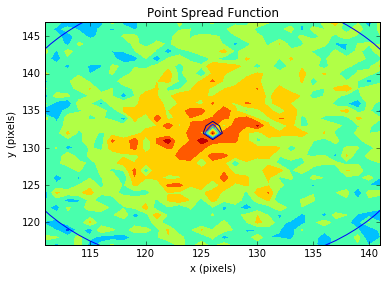

In [12]:
center_prob = center_prob_rav.reshape(x_arr.shape[0], x_arr.shape[1])
       
pyplot.contourf(star_data, edgecolors='face')
prob_cont = pyplot.contour(x_arr, y_arr, symm_2d_gaussian((x_arr,y_arr), *p_opt), colors='blue', label='PSF', levels=[(0.24/7)*F0+B0])
print(prob_cont.levels)
pyplot.contour(x_arr, y_arr, center_prob)
pyplot.axis([111, 141, 117, 147])
pyplot.xlabel('x (pixels)')
pyplot.ylabel('y (pixels)')
title = pyplot.title('Point Spread Function')
    

In [13]:
import warnings
 

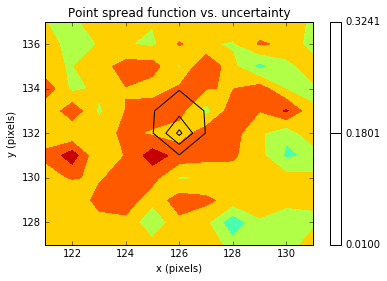

In [14]:
mp = center_prob.max() # maximum probability 
prob_cont = pyplot.contour(x_arr, y_arr, center_prob, colors='black', levels=[0.01, 0.5*mp, 0.9*mp], label='uncertainty')
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plots = [ pyplot.contourf(star_data, edgecolors='face') ]
    psf_cont = pyplot.contour(x_arr, y_arr, symm_2d_gaussian((x_arr,y_arr), *p_opt), colors='blue', label='PSF', levels=[0.24, 0.98, 0.997])
    plots.append(psf_cont)
    plots.append(prob_cont)
    pyplot.colorbar(prob_cont)
    pyplot.axis([121, 131, 127, 137])
    pyplot.xlabel('x (pixels)')
    pyplot.ylabel('y (pixels)')
    pyplot.title('Point spread function vs. uncertainty')
    #pyplot.legend(plots, loc='center left', bbox_to_anchor=(1., 0.5))

    

As we can see, the fits look great! The legend for this plot isn't working, but the inner black contours are for the 

<h3>Subtract the source fit</h3>

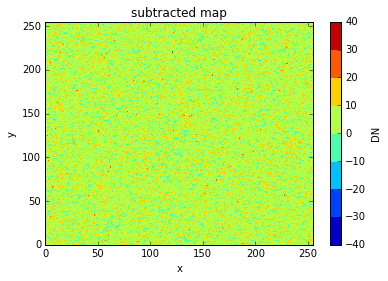

In [15]:
blank_sky = star_data - symm_2d_gaussian((x_arr,y_arr), *p_opt)
contour = pyplot.contourf(blank_sky, edgecolors='face')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.title("subtracted map")
cbar = pyplot.colorbar(label='DN')


I am not positive that the relationship of standard deviations is simply $\sigma_{DN}=\frac{1}{k}\sigma_N$, I will test it by running the same optimization on the data in units of photoelectrons, and comparing the variance of $F$:  
It appears that this works, as the variance goes up as $k^2$


In [16]:
k = 3.0 # gain 
star_data_pe = k * star_data
sigma_array_pe = numpy.sqrt(star_data_pe)
p_opt_pe, p_cov_pe = optimize.curve_fit(symm_2d_gaussian, (x_rav, y_rav), star_data_pe.ravel(), init_guess, sigma_array_pe.ravel())
print("new variance: {0:0.3f}".format(p_cov_pe[0][0]))
print("ratio of photoelectron variance to DN variance: {0:0.3f}".format(p_cov_pe[0][0]/p_cov[0][0]))


new variance: 5.751
ratio of photoelectron variance to DN variance: 8.992


<h3>Marginal probability distribution of flux</h3>

In [17]:
def gaussian_1d(x, mean, sigma):
    return numpy.exp(-(x-mean)**2/(2*sigma))/(numpy.sqrt(2*numpy.pi)*sigma)

In [18]:
F_range = 5. * F_sig
num_points = 10000

F0_arr = F0 * numpy.ones(num_points) 
F_sig_arr = F_sig * numpy.ones(num_points)
F_arr = numpy.arange(F0-F_range/2, F0+F_range/2, F_range/num_points)
marg_prob_F_arr = gaussian_1d(F_arr, F0_arr, F_sig_arr)



ValueError: operands could not be broadcast together with shapes (10001,) (10000,) 

In [ ]:
pyplot.plot(F_arr, marg_prob_F_arr)
title = pyplot.title("marginal probability density of flux")
xlabel = pyplot.xlabel('$F (DN)$')
ylabel = pyplot.ylabel('$p(F\mid D)$')